**Install requirements**

In [1]:
!pip install MDAnalysis pandas -q

### **1. Execute this if the `.gro` file has not been segregated**

In [6]:
import ipywidgets as widgets
from IPython.display import display
import os

def decompose_gro_file(merged_file, output_prefix):
    with open(merged_file, 'r') as file:
        lines = file.readlines()

    frame_start_indices = [i for i, line in enumerate(lines) if line.startswith('Generated')]
    num_frames = len(frame_start_indices)

    for i in range(num_frames):
        start_index = frame_start_indices[i]
        if i < num_frames - 1:
            end_index = frame_start_indices[i + 1]
        else:
            end_index = len(lines)

        frame_lines = lines[start_index:end_index]

        # Extract the frame number from the "Generated by" line
        frame_number = i + 1
        frame_lines[0] = frame_lines[0].replace('Generated by trjconv', f'frame_{frame_number}')

        output_file = f"{output_prefix}_{frame_number}.gro"
        with open(output_file, 'w') as file:
            file.writelines(frame_lines)

# Usage example
merged_file = os.path.join(os.getcwd(), './source_trj/prod_trjconv_SOL.gro')
output_prefix = './segregated/frame'
decompose_gro_file(merged_file, output_prefix)

# echo
print("INFO: Decomposition completed. The output files are in the './segregated' directory.")

INFO: Decomposition completed. The output files are in the './segregated' directory.


### **2. Run and find F4 values per frame**

In [7]:
import math
import numpy as np
import MDAnalysis as mda
import warnings
import os

def calculate_f4(universe):
    f4_values = []
    water_molecules = universe.select_atoms("resname SOL")
    oxygen_atoms = water_molecules.select_atoms("name O")
    hydrogen_atoms = water_molecules.select_atoms("name H")
    virtual_sites = water_molecules.select_atoms("name M")

    # Set the masses of virtual sites to zero to suppress the warning
    virtual_sites.masses = 0.0

    for frame in universe.trajectory:
        phi_avg = 0
        num_pairs = 0

        for i in range(len(oxygen_atoms)):
            for j in range(i+1, len(oxygen_atoms)):
                o1 = oxygen_atoms[i]
                o2 = oxygen_atoms[j]
                h1_candidates = hydrogen_atoms[i*2:(i+1)*2]
                h2_candidates = hydrogen_atoms[j*2:(j+1)*2]

                distances = []
                for h1 in h1_candidates:
                    for h2 in h2_candidates:
                        dist_o1_h2 = calculate_distance(o1, h2)
                        dist_o2_h1 = calculate_distance(o2, h1)
                        distances.append((dist_o1_h2, dist_o2_h1, h1, h2))

                distances.sort()
                _, _, h1, h2 = distances[0]

                phi = calculate_torsion_angle(h1, o1, o2, h2)
                cos_3phi = math.cos(3 * phi)
                phi_avg += cos_3phi
                num_pairs += 1

        f4 = phi_avg / num_pairs
        f4_values.append(f4)

    return np.array(f4_values)

def calculate_distance(atom1, atom2):
    dx = atom1.position[0] - atom2.position[0]
    dy = atom1.position[1] - atom2.position[1]
    dz = atom1.position[2] - atom2.position[2]
    return math.sqrt(dx**2 + dy**2 + dz**2)

def calculate_torsion_angle(atom1, atom2, atom3, atom4):
    v1 = atom1.position - atom2.position
    v2 = atom3.position - atom2.position
    v3 = atom4.position - atom3.position

    n1 = np.cross(v1, v2)
    n2 = np.cross(v2, v3)

    cos_phi = np.dot(n1, n2) / (np.linalg.norm(n1) * np.linalg.norm(n2))
    sin_phi = np.dot(v2, np.cross(n1, n2)) / (np.linalg.norm(v2) * np.linalg.norm(np.cross(n1, n2)))
    phi = math.atan2(sin_phi, cos_phi)

    return phi

# Suppress the warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Directory containing the frame files
frame_dir = "./segregated/"

# Output file to store the frame - F4 values
output_file = "frame_f4_values.csv"

# Get the list of frame files
frame_files = [file for file in os.listdir(frame_dir) if file.endswith(".gro")]

# Sort the frame files based on their numerical frame number
frame_files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))

# Open the output file in write mode
with open(output_file, "w") as file:
    # Iterate over the sorted frame files
    for frame_file in frame_files:
        # Load the frame file
        universe = mda.Universe(os.path.join(frame_dir, frame_file))

        # Calculate the F4 order parameter for the frame
        f4_value = calculate_f4(universe)

        # Extract the frame number from the file name
        frame_number = frame_file.split("_")[1].split(".")[0]

        # Write the frame - F4 value to the output file
        file.write(f"{frame_number},{f4_value[0]}\n")

        # Print the frame - F4 value in the shell
        print(f"{frame_number},{f4_value[0]}")

1,0.16803680968136386
2,0.298460690279075
3,-0.548265463039205
4,0.2206492688636402
5,0.07142864914968847
6,0.17844661437250695
7,-0.05736835645757173
8,-0.28873006258953005
9,-0.3107745768183056
10,-0.1080877949981645
11,-0.2988014943962144
12,-0.318804925030563
13,0.10296889222912697
14,0.16385158699834737
15,-0.013346441388876678
16,0.25239613131311844
17,-0.1672837250135002
18,0.18506807191079666
19,0.2973797576266791
20,0.47162860043183585
21,0.15279705118866002
22,0.4860650433551217
23,0.16746927590714542
24,0.04389117716183799
25,0.14134485880618292
26,0.046423023115104746
27,-0.427236352500616
28,0.13393405016386545
29,0.07732878364430049
30,-0.09310212297156059
31,-0.19344431803906756
32,-0.01886915998141201
33,-0.2750254726557299
34,0.21822322509702935
35,-0.4235839205755953
36,-0.10482388699621965
37,-0.17173531557774205
38,-0.02223356232517362
39,-0.16390647111985213
40,0.21583680082105952
41,0.09398388612464177
42,-0.2872716591382435
43,0.344819561315593
44,0.1805079734737

### **3. Plot `F4 - frame` graph**

**Raw plot**

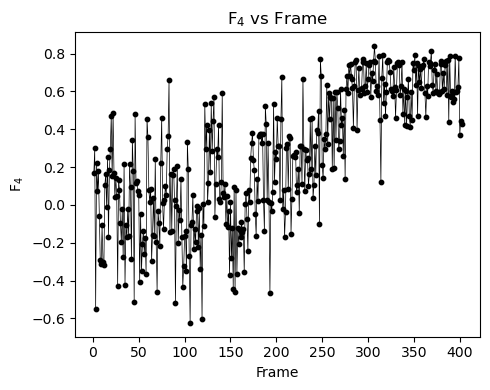

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('frame_f4_values.csv', header=None)

# make header
df.columns = ['frame', 'f4']

# plot
fig = plt.figure(figsize = (5, 4))
plt.scatter(df['frame'], df['f4'], color = 'k', s = 10)
plt.plot(df['frame'], df['f4'], color = 'k', lw = 0.5)
plt.xlabel('Frame')
plt.ylabel(r'F$_4$')
plt.title(r'F$_4$ vs Frame')
plt.tight_layout()
plt.savefig('f4_vs_frame_raw.png', dpi = 400, bbox_inches = 'tight')

**With raw and moving avg**

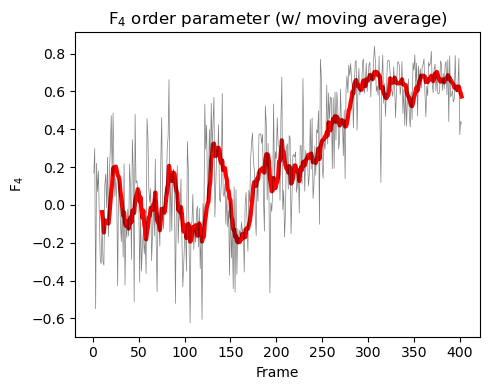

In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# moving average
rolling_value = 10

# read data
df = pd.read_csv('frame_f4_values.csv', header=None)

# make header
df.columns = ['frame', 'f4']

# calculate moving average
df['f4_rolling'] = df['f4'].rolling(rolling_value).mean()

# plot both original and moving average

## moving average
fig = plt.figure(figsize = (5, 4))
plt.plot(df['frame'], df['f4_rolling'], color = 'r', linewidth=3)

## original 
plt.plot(df['frame'], df['f4'], alpha=0.5, color = 'k', linewidth=0.5)

# Labeling 
plt.xlabel('Frame')
plt.ylabel(r'F$_4$')
plt.title(r'F$_4$ order parameter (w/ moving average)')

plt.tight_layout()

plt.savefig('f4_vs_frame_rolling.png', dpi=400, bbox_inches='tight')